In [108]:
import torch.nn as nn
import torch 
import random 
import gym
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

from actor_critic import ActorCritic


def run_episodes_policy_gradient(env, num_episodes, max_steps, discount_factor, learn_rate, n_hidden=256):
    
    n_state_features = len(env.reset())
    n_actions = env.action_space.n
    
    model =  ActorCritic(n_state_features, n_actions, n_hidden)
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []

    # loop for each episode
    for episode in range(num_episodes):
        
        # initialize S (first state of episode)
        s = env.reset()
        I = 1
        step = 0
        
        while True:
            
            optimizer.zero_grad()
            
            v_s, pi_s_a = model.forward(s)
            
            # select action
            a = torch.multinomial(torch.exp(pi_s_a), 1).item()  
            log_prob = torch.log(pi_s_a.squeeze(0)[a])
            
            # take action
            s_new, r, done, _ = env.step(a)
            
            # compute delta 
            v_s_new = 0 
            if not done:
                v_s_new, _ = model.forward(s_new)
                v_s_new = v_s_new.item() 
            delta = r + gamma * v_s_new - v_s.item()
            
            # from another github where the whole thing works:
            # adv = r - v_s.item()
            # loss_a = -log_prob * adv
            # loss_c = torch.nn.functional.smooth_l1_loss(v_s, torch.Tensor([r]).float())
            
            # compute gradient
            loss_a =  - delta * I * log_prob
            loss_c =  delta * v_s # should this be negative or positive?
            loss = loss_a + loss_c
            
            # backprop
            loss.backward()
            optimizer.step()
            
            I = discount_factor*I
            s = s_new
            step += 1
            
            # until s is a terminal state or we used the max steps
            if done or step > max_steps:
                break
            
        if episode % 10 == 0:
            #print("E{0}- Steps:{1} Loss:{2}".format(episode, step, loss))
            pass
                  
        episode_durations.append(step)
        
    return episode_durations



Loop for each step of the episode $t=0,1, \ldots, T-1:$
$$
\begin{array}{l}{G \leftarrow \sum_{k=t+1}^{T} \gamma^{k-t-1} R_{k}} \\ {\boldsymbol{\theta} \leftarrow \boldsymbol{\theta}+\alpha \gamma^{t} G \nabla \ln \pi\left(A_{t} | S_{t}, \boldsymbol{\theta}\right)}\end{array}
$$
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$



Here we have
Take action $A,$ observe $S^{\prime}, R$ 
$$
\delta \leftarrow R+\gamma \hat{v}\left(S^{\prime}, \mathbf{w}\right)-\hat{v}(S, \mathbf{w}) \\
\mathbf{w} \leftarrow \mathbf{w}+\alpha^{\mathbf{w}} \delta \nabla \hat{v}(S, \mathbf{w}) \\ \boldsymbol{\theta} \leftarrow \boldsymbol{\theta}+\alpha^{\boldsymbol{\theta}} I \delta \nabla \ln \pi(A | S, \boldsymbol{\theta})
$$

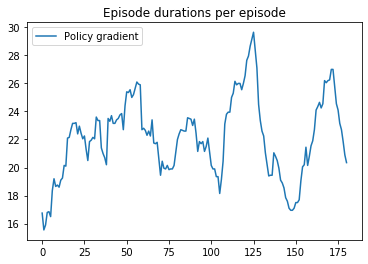

In [114]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

num_episodes = 200
discount_factor = 0.99
learn_rate = 0.01
seed = 42
random.seed(seed)
torch.manual_seed(seed)

env = gym.envs.make("CartPole-v0")
env.seed(seed)

gamma = .99
lr = 3e-2
num_episodes = 200
max_steps =  300 # max steps per episode

episode_durations_policy_gradient = run_episodes_policy_gradient(env, 
                                                                 num_episodes, 
                                                                 max_steps,
                                                                 discount_factor, 
                                                                 learn_rate,
                                                                 n_hidden=256)
plt.plot(smooth(episode_durations_policy_gradient, 20))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])